In [2]:
!pip install plotly


   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
    --------------------------------------- 0.3/16.1 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.1 MB 2.7 MB/s eta 0:00:06
   --- ------------------------------------ 1.6/16.1 MB 2.5 MB/s eta 0:00:06
   ----- ---------------------------------- 2.1/16.1 MB 2.6 MB/s eta 0:00:06
   ------ --------------------------------- 2.6/16.1 MB 2.7 MB/s eta 0:00:06
   ------- -------------------------------- 3.1/16.1 MB 2.7 MB/s eta 0:00:05
   --------- ------------------------------ 3.7/16.1 MB 2.7 MB/s eta 0:00:05
   ---------- ----------------------------- 4.2/16.1 MB 2.7 MB/s eta 0:00:05
   ----------- ---------------------------- 4.7/16.1 MB 2.7 MB/s eta 0:00:05
   ------------- -------------------------- 5.5/16.1 MB 2.7 MB/s eta 0:00:04
   -------------- ------------------------- 5.8/16.1 MB 2.6 MB/s eta 0:00:05
   ---------------- ----------------------- 6.6/16.1 MB 2.7 MB/s eta 0:00:04
   ----------

In [5]:
!pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.5 MB/s eta 0:00:00


##  Import Necessary Libraries

In [6]:
#import all the important libraries
# --- Basic libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# --- Date and time handling ---
import datetime

# --- Preprocessing & encoding ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

# --- Distance metrics ---
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances

# --- Clustering ---
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# --- Association rule mining ---
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# --- Classification models ---
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')


## Load the Dataset

In [10]:
#Load the dataset
df=pd.read_csv('Online Retail.csv')

## Explore Dataset Shape and Column Names

In [11]:
#lets exoplore the data 
# Shape of dataset
print("Shape of dataset:", df.shape)

# Column names
print("Column names:\n", df.columns.tolist())


Shape of dataset: (541909, 8)
Column names:
 ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


## Check for Missing Values

In [12]:
#check missing values 
# Count missing values per column
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Description      1454
CustomerID     135080
dtype: int64


## Check Column Data Types

In [13]:
#check data type of columns 
df.dtypes


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Display Summary Statistics

In [14]:
#summary statistics 
df.describe()


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Check for Duplicate Rows

In [15]:
# Check if any duplicates exist
print("Number of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 5268


## Explore Unique Values in Key Columns

In [16]:
#explore unique values in the key columns 

# Unique number of customers
print("Unique Customers:", df['CustomerID'].nunique())

# Unique countries
print("Unique Countries:", df['Country'].nunique())

# Top 5 countries by transactions
print("Top 5 Countries:\n", df['Country'].value_counts().head())


Unique Customers: 4372
Unique Countries: 38
Top 5 Countries:
 Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64


## Distribution of Qunatity and Unit Price

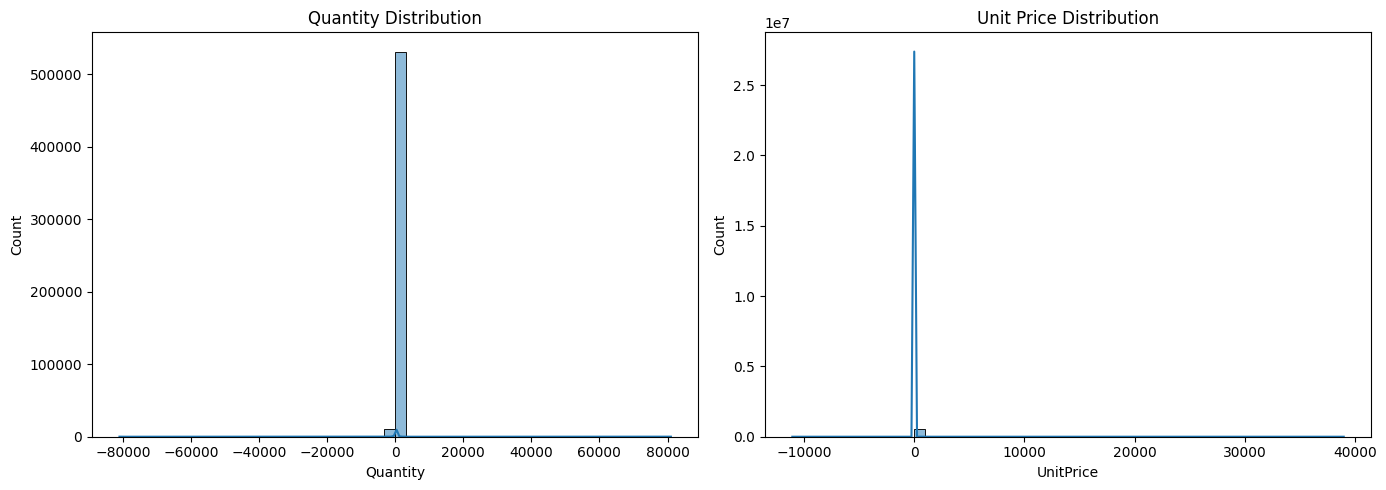

In [17]:
#distribution of Qunatity and Unit Price
# Plot histograms
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title('Quantity Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title('Unit Price Distribution')

plt.tight_layout()
plt.show()


## Data Preprocessing and Data ingestion

In [18]:
#Data Preprocessing and Data ingestion
#clean the data

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Add TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']




In [19]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


## Calculate Recency, Frequency, and Monetary (RFM) Values

In [21]:
# Set snapshot date = 1 day after the last purchase
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalAmount': 'sum'                                       # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Reset index
rfm = rfm.reset_index()

# Preview RFM table
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## One-Hot coding

In [22]:
#one hot encoding of country 
# Create customer-country mapping
customer_country = df.groupby('CustomerID')['Country'].first().reset_index()

# One-hot encode Country
country_encoded = pd.get_dummies(customer_country, columns=['Country'])

# Merge with RFM
rfm = pd.merge(rfm, country_encoded, on='CustomerID', how='left')


In [23]:
 # Similarity & Dissimilarity Matrices
from sklearn.metrics.pairwise import euclidean_distances


## Normalize RFM features

In [27]:
# Normalize RFM features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

## Compute pairwise Euclidean distance

In [28]:
# Compute pairwise Euclidean distance
euclidean_matrix = euclidean_distances(rfm_scaled)

In [29]:
euclidean_matrix

array([[0.        , 8.76661992, 8.76433162, ..., 9.14035912, 9.16330751,
        8.85231136],
       [8.76661992, 0.        , 0.87333038, ..., 0.797578  , 1.1940199 ,
        0.71648043],
       [8.76433162, 0.87333038, 0.        , ..., 0.74078345, 1.7120317 ,
        0.34535429],
       ...,
       [9.14035912, 0.797578  , 0.74078345, ..., 0.        , 1.83000682,
        0.41645581],
       [9.16330751, 1.1940199 , 1.7120317 , ..., 1.83000682, 0.        ,
        1.7320269 ],
       [8.85231136, 0.71648043, 0.34535429, ..., 0.41645581, 1.7320269 ,
        0.        ]], shape=(4339, 4339))

## Visualize Euclidean Distance as a Heatmap

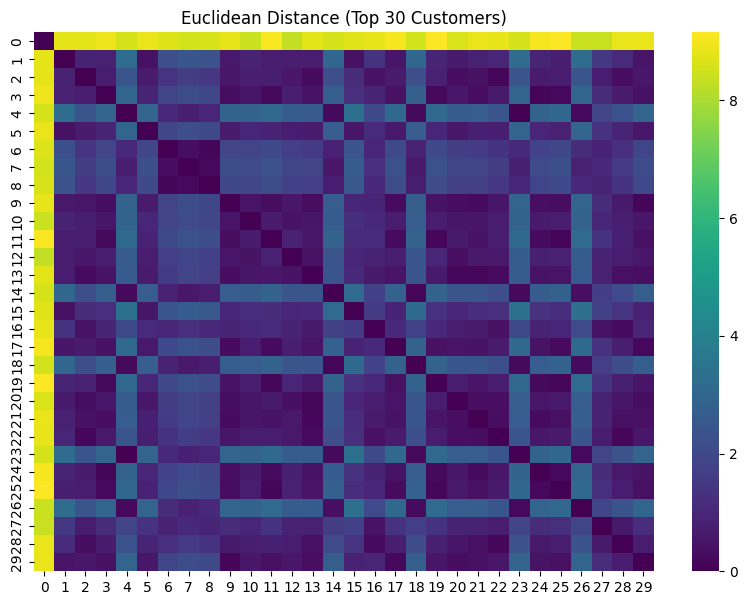

In [30]:
# Visualize as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(euclidean_matrix[:30, :30], cmap='viridis')  # only first 30 for visibility
plt.title("Euclidean Distance (Top 30 Customers)")
plt.show()

## Jaccard Similarity on Top 10 Purchased StockCodes

In [31]:
#Jaccard Similarity on Top 10 Purchased StockCodes
from sklearn.metrics import jaccard_score
from itertools import combinations


In [34]:
#Get top 10 StockCodes for each customer
top10_items = df.groupby('CustomerID')['StockCode'].apply(lambda x: x.value_counts().head(10).index.tolist())

#Convert to binary matrix
unique_items = list(set([item for sublist in top10_items for item in sublist]))
binary_matrix = pd.DataFrame(0, index=top10_items.index, columns=unique_items)




In [35]:
for cust_id, items in top10_items.items():
    binary_matrix.loc[cust_id, items] = 1

# Compute Jaccard similarity (for first 30 customers to keep it small)
jaccard_sim = np.zeros((30, 30))
ids = binary_matrix.index[:30]

for i, a in enumerate(ids):
    for j, b in enumerate(ids):
        jaccard_sim[i, j] = jaccard_score(binary_matrix.loc[a], binary_matrix.loc[b])

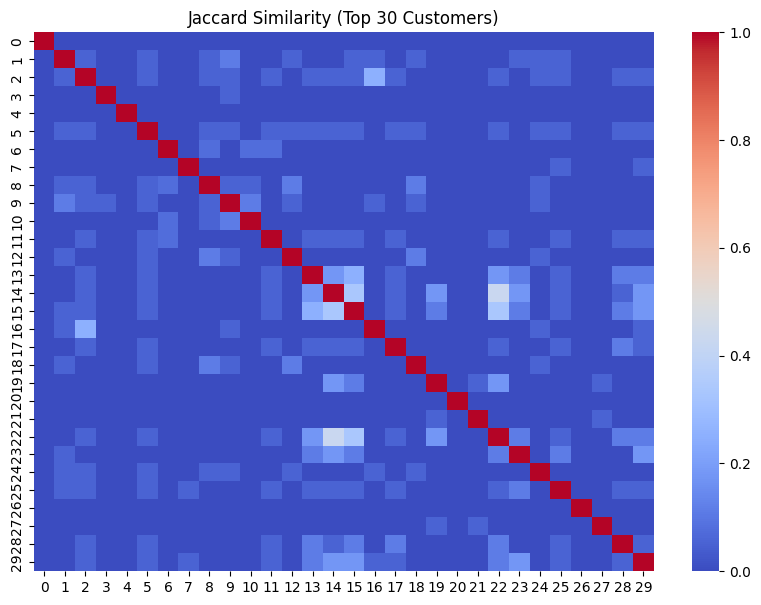

In [36]:
# Plot Jaccard heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(jaccard_sim, cmap='coolwarm')
plt.title("Jaccard Similarity (Top 30 Customers)")
plt.show()

## Determine Optimal Number of Clusters using Elbow and Silhouette Methods

In [37]:
#3.1
#kmeans 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [38]:

# Normalize RFM again (if not already done)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [39]:
# Find optimal K using Elbow and Silhouette
inertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

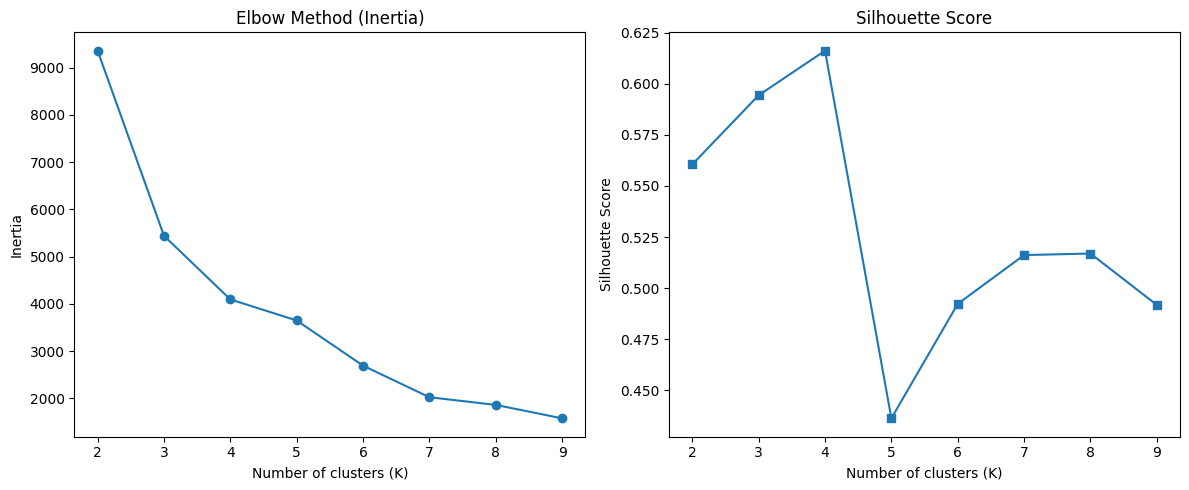

In [41]:
# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='s')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

## Apply K-Means Clustering and Visualize with PCA

In [43]:
#Fit final k means with chosen k
 #Choose best K (e.g. 4 from elbow/silhouette)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm['KMeansCluster'] = kmeans.fit_predict(rfm_scaled)

# Reduce to 2D with PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

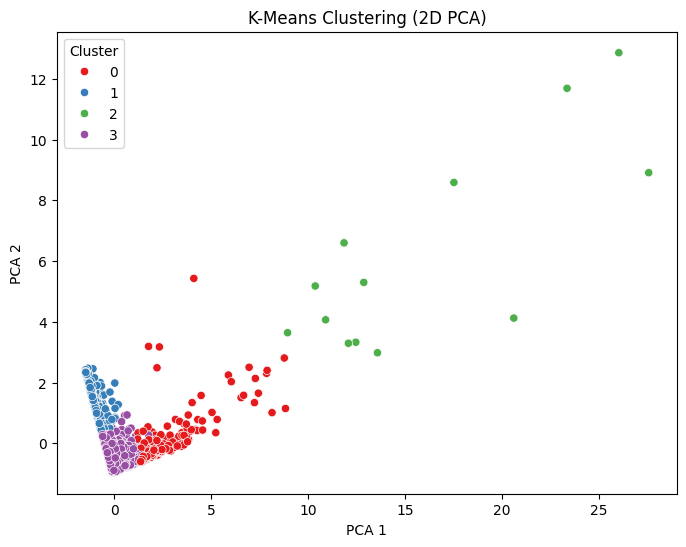

In [44]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['KMeansCluster'], palette='Set1')
plt.title("K-Means Clustering (2D PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

## Apply DBSCAN Clustering and Visualize with PCA

In [45]:
#3.2 
#DBSCAN Clustering

from sklearn.cluster import DBSCAN

# DBSCAN - tune eps and min_samples
dbscan = DBSCAN(eps=1.2, min_samples=5)
rfm['DBSCANCluster'] = dbscan.fit_predict(rfm_scaled)

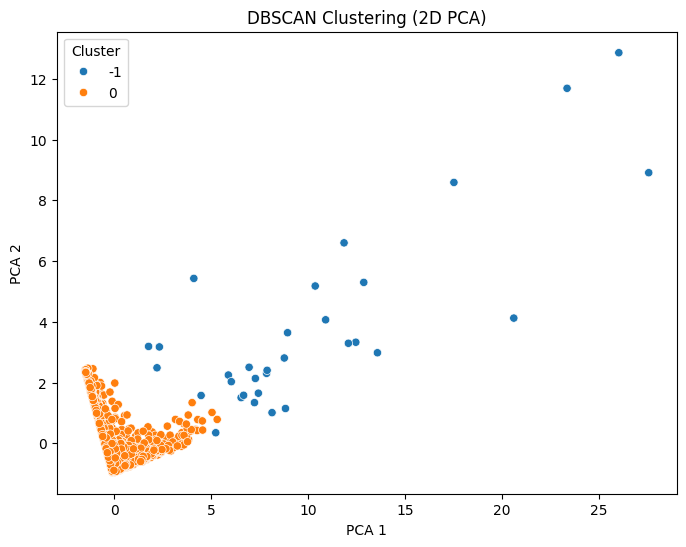

In [46]:
# Plot DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['DBSCANCluster'], palette='tab10')
plt.title("DBSCAN Clustering (2D PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

## Prepare Basket Data for Association Rule Mining

In [47]:
#4.1
#prepare basket data 
# Create basket: rows → invoices, columns → items (StockCodes), values → 1 or 0
basket = df.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)

# Convert quantities to binary (presence of item)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

basket.head()


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply and Compare Apriori and FP-Growth Algorithms for Association Rule Mining

In [48]:
#apriori algorithm 
from mlxtend.frequent_patterns import apriori, association_rules
import time

# Run Apriori
start = time.time()
frequent_apriori = apriori(basket, min_support=0.02, use_colnames=True)
rules_apriori = association_rules(frequent_apriori, metric='lift', min_threshold=1.2)
rules_apriori = rules_apriori[(rules_apriori['confidence'] >= 0.6)]
end = time.time()

apriori_runtime = round(end - start, 2)


In [49]:
apriori_runtime

12.69

In [50]:
#fp growth algorithm

from mlxtend.frequent_patterns import fpgrowth

# Run FP-Growth
start = time.time()
frequent_fpgrowth = fpgrowth(basket, min_support=0.02, use_colnames=True)
rules_fpgrowth = association_rules(frequent_fpgrowth, metric='lift', min_threshold=1.2)
rules_fpgrowth = rules_fpgrowth[(rules_fpgrowth['confidence'] >= 0.6)]
end = time.time()

fpgrowth_runtime = round(end - start, 2)

fpgrowth_runtime


12.77

In [51]:
#4.4
# Top 10 rules by lift (Apriori)
top10_apriori = rules_apriori.sort_values(by='lift', ascending=False).head(10)
print("Top 10 Apriori Rules:")
display(top10_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']])



Top 10 Apriori Rules:


,antecedents,consequents,support,confidence,lift
87,(22698),"(22697, 22699)",0.021040,0.701439,24.033032
82,"(22697, 22699)",(22698),0.021040,0.720887,24.033032
83,"(22698, 22699)",(22697),0.021040,0.894495,23.994742
56,(22697),(22698),0.024817,0.665702,22.193256
57,(22698),(22697),0.024817,0.827338,22.193256
84,"(22697, 22698)",(22699),0.021040,0.847826,20.070631
61,(22698),(22699),0.023522,0.784173,18.563760
58,(22697),(22699),0.029186,0.782923,18.534184
59,(22699),(22697),0.029186,0.690932,18.534184
55,(22629),(22630),0.022874,0.602273,18.122934


In [52]:
# Top 10 rules by lift (FP-Growth)
top10_fpgrowth = rules_fpgrowth.sort_values(by='lift', ascending=False).head(10)
print("Top 10 FP-Growth Rules:")
display(top10_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 FP-Growth Rules:


,antecedents,consequents,support,confidence,lift
66,"(22697, 22699)",(22698),0.021040,0.720887,24.033032
71,(22698),"(22697, 22699)",0.021040,0.701439,24.033032
67,"(22698, 22699)",(22697),0.021040,0.894495,23.994742
62,(22697),(22698),0.024817,0.665702,22.193256
63,(22698),(22697),0.024817,0.827338,22.193256
68,"(22697, 22698)",(22699),0.021040,0.847826,20.070631
65,(22698),(22699),0.023522,0.784173,18.563760
58,(22697),(22699),0.029186,0.782923,18.534184
59,(22699),(22697),0.029186,0.690932,18.534184
54,(22630),(22629),0.022874,0.688312,18.122934


In [53]:
print("Apriori Runtime: ", apriori_runtime, "seconds")
print("FP-Growth Runtime: ", fpgrowth_runtime, "seconds")


Apriori Runtime:  12.69 seconds
FP-Growth Runtime:  12.77 seconds


## Build and Evaluate Naive Bayes Classification Models

In [60]:
#5 
# GaussianNB Pipeline (RFM Features)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# Features and target
X_rfm = rfm[['Recency', 'Frequency', 'Monetary']]
y_rfm = rfm['HighValue']

# Train-test split
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.2, random_state=42)

# Pipeline
gnb_pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Scale numeric features
    ('classifier', GaussianNB())          # Classifier
])

# Fit
gnb_pipeline.fit(X_train_rfm, y_train_rfm)

# Predict
y_pred_gnb = gnb_pipeline.predict(X_test_rfm)
y_prob_gnb = gnb_pipeline.predict_proba(X_test_rfm)[:, 1]


## BernoulliNB Pipeline

In [61]:
#BernoulliNB Pipeline (Binary Purchase Flags)

from sklearn.naive_bayes import BernoulliNB

# Binary purchase matrix
purchase_flags = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().unstack().fillna(0)
purchase_flags = purchase_flags.applymap(lambda x: 1 if x > 0 else 0)

# Match labels
purchase_flags = purchase_flags.loc[purchase_flags.index.isin(rfm['CustomerID'])]
y_flags = rfm.set_index('CustomerID').loc[purchase_flags.index]['HighValue']

# Train-test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(purchase_flags, y_flags, test_size=0.2, random_state=42)

# Pipeline (no scaler needed for BernoulliNB)
bnb_pipeline = Pipeline([
    ('classifier', BernoulliNB())
])

# Fit
bnb_pipeline.fit(X_train_bin, y_train_bin)

# Predict
y_pred_bnb = bnb_pipeline.predict(X_test_bin)
y_prob_bnb = bnb_pipeline.predict_proba(X_test_bin)[:, 1]


In [62]:
#evalujate functions

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_test, y_pred, y_prob, model_name):
    print(f"\nModel: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()



Model: GaussianNB (RFM Features)
[[627  16]
 [ 26 199]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       643
           1       0.93      0.88      0.90       225

    accuracy                           0.95       868
   macro avg       0.94      0.93      0.94       868
weighted avg       0.95      0.95      0.95       868



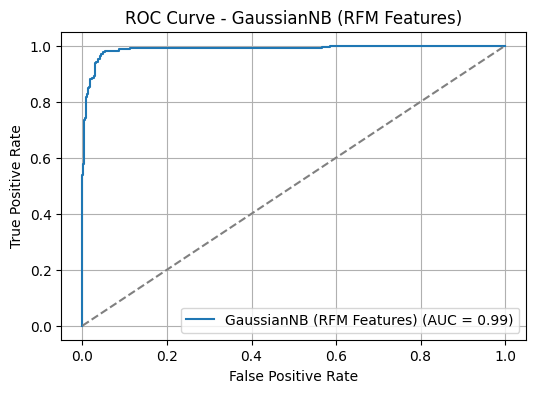

In [63]:
#Evaluate GaussianNB (on RFM)
evaluate_model(y_test_rfm, y_pred_gnb, y_prob_gnb, "GaussianNB (RFM Features)")



Model: BernoulliNB (Purchase Flags)
[[573  70]
 [ 68 157]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       643
           1       0.69      0.70      0.69       225

    accuracy                           0.84       868
   macro avg       0.79      0.79      0.79       868
weighted avg       0.84      0.84      0.84       868



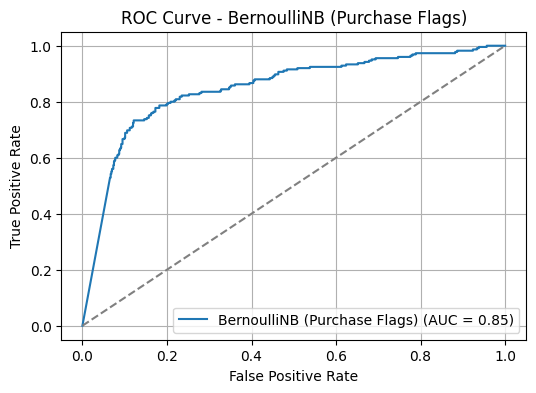

In [64]:
evaluate_model(y_test_bin, y_pred_bnb, y_prob_bnb, "BernoulliNB (Purchase Flags)")


## Advanced Classification with Support Vector Machines (SVM) and Project Visualization

In [65]:
#6
#SVM Pipeline for RFM Data (Linear + RBF)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Linear SVM
svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True))
])

# RBF SVM with GridSearchCV
param_grid_rbf = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01, 0.1, 1]
}

svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True))
])

grid_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5)


In [66]:
# Train and Predict
# Linear SVM
svm_linear.fit(X_train_rfm, y_train_rfm)
y_pred_linear = svm_linear.predict(X_test_rfm)
y_prob_linear = svm_linear.predict_proba(X_test_rfm)[:, 1]



In [67]:
# RBF SVM
grid_rbf.fit(X_train_rfm, y_train_rfm)
y_pred_rbf = grid_rbf.predict(X_test_rfm)
y_prob_rbf = grid_rbf.predict_proba(X_test_rfm)[:, 1]


Model: SVM (Linear Kernel)
[[637   6]
 [ 16 209]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       643
           1       0.97      0.93      0.95       225

    accuracy                           0.97       868
   macro avg       0.97      0.96      0.97       868
weighted avg       0.97      0.97      0.97       868



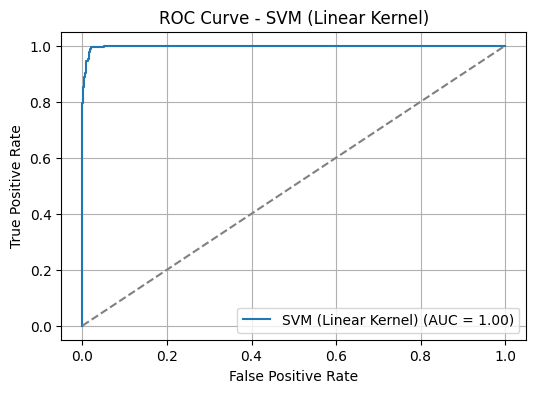


Model: SVM (RBF Kernel)
[[639   4]
 [  3 222]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       643
           1       0.98      0.99      0.98       225

    accuracy                           0.99       868
   macro avg       0.99      0.99      0.99       868
weighted avg       0.99      0.99      0.99       868



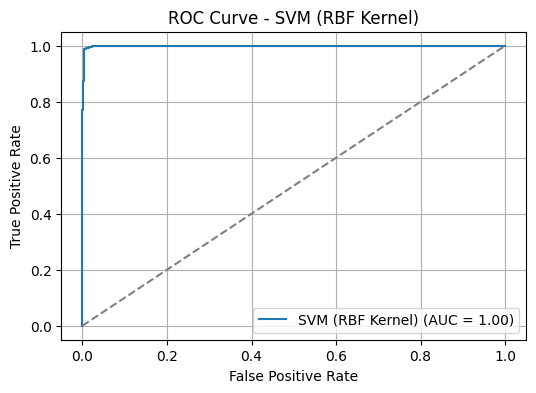

In [68]:
#Evaluate Both Models
evaluate_model(y_test_rfm, y_pred_linear, y_prob_linear, "SVM (Linear Kernel)")
evaluate_model(y_test_rfm, y_pred_rbf, y_prob_rbf, "SVM (RBF Kernel)")


##  Visualize Decision Boundaries (PCA)

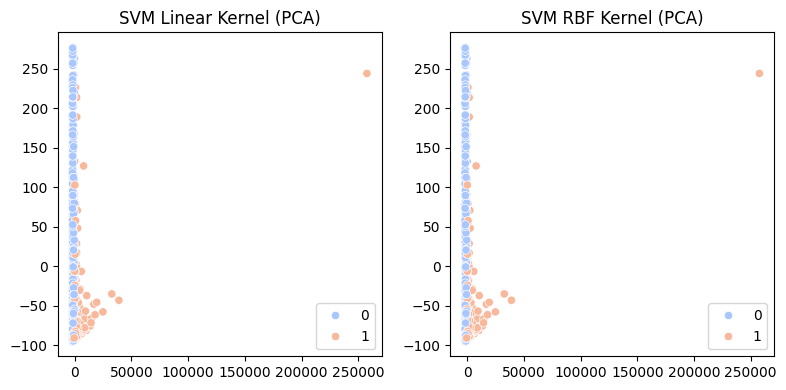

In [69]:
# Visualize Decision Boundaries (PCA)
# Reduce dimensions for plotting
pca = PCA(n_components=2)
X_rfm_pca = pca.fit_transform(X_test_rfm)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_rfm_pca[:, 0], y=X_rfm_pca[:, 1], Ahue=y_pred_linear, palette='coolwarm')
plt.title("SVM Linear Kernel (PCA)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_rfm_pca[:, 0], y=X_rfm_pca[:, 1], hue=y_pred_rbf, palette='coolwarm')
plt.title("SVM RBF Kernel (PCA)")

plt.tight_layout()
plt.show()


In [70]:
#summary table of test accuracies 

from sklearn.metrics import accuracy_score

results = pd.DataFrame({
    "Model": ["SVM Linear", "SVM RBF (Best Grid)"],
    "Accuracy": [
        accuracy_score(y_test_rfm, y_pred_linear),
        accuracy_score(y_test_rfm, y_pred_rbf)
    ]
})

print(results)


                 Model  Accuracy
0           SVM Linear  0.974654
1  SVM RBF (Best Grid)  0.991935


## Customer Segments Based on RFM (3D Plot)

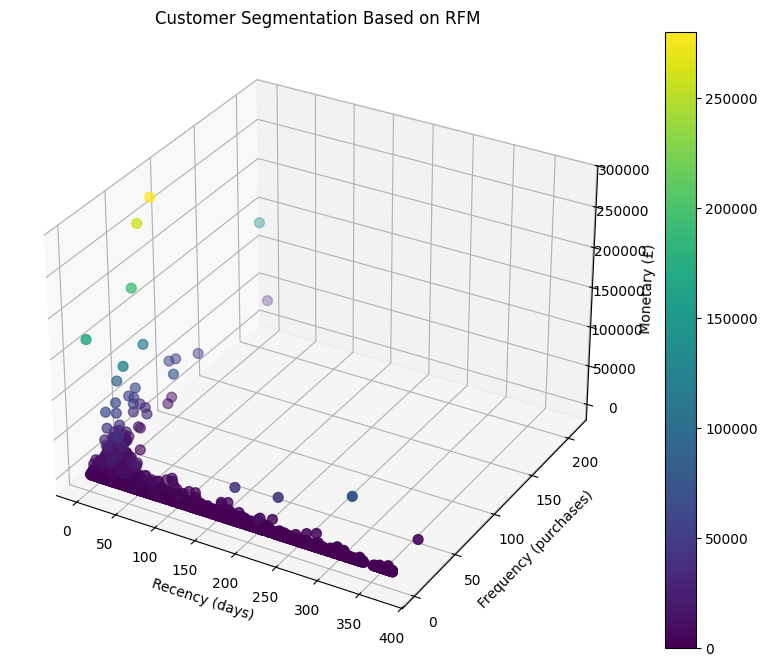

In [71]:
# lest visuulaize  our project 

#Customer Segments Based on RFM (3D Plot)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
                c=rfm['Monetary'], cmap='viridis', s=50)
ax.set_xlabel('Recency (days)')
ax.set_ylabel('Frequency (purchases)')
ax.set_zlabel('Monetary (£)')
plt.title('Customer Segmentation Based on RFM')
plt.colorbar(sc)
plt.show()


## Top 10 Most Purchased Products

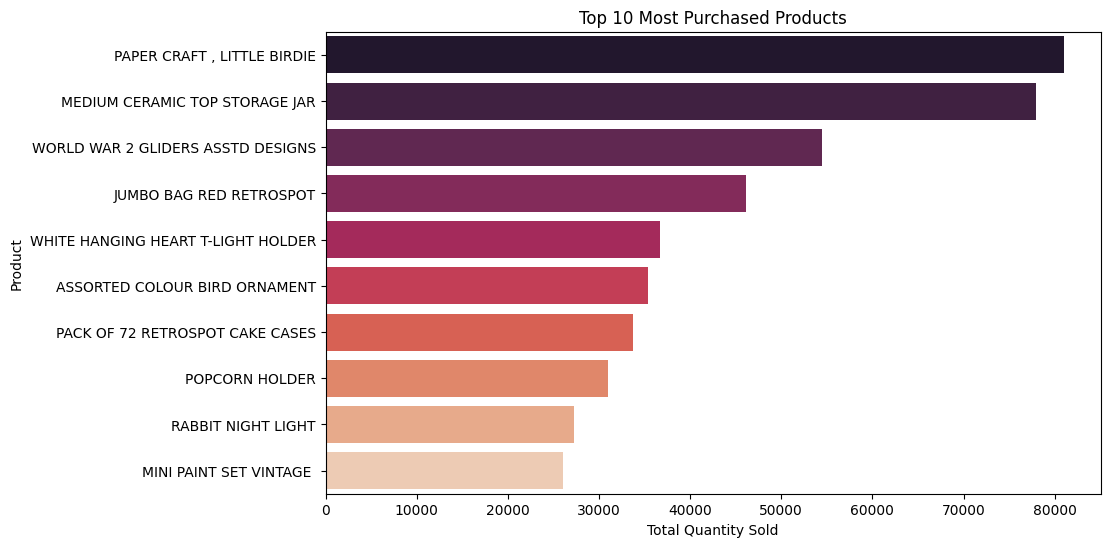

In [72]:
#. Top 10 Most Purchased Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='rocket')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.show()


## Monthly Sales Trend

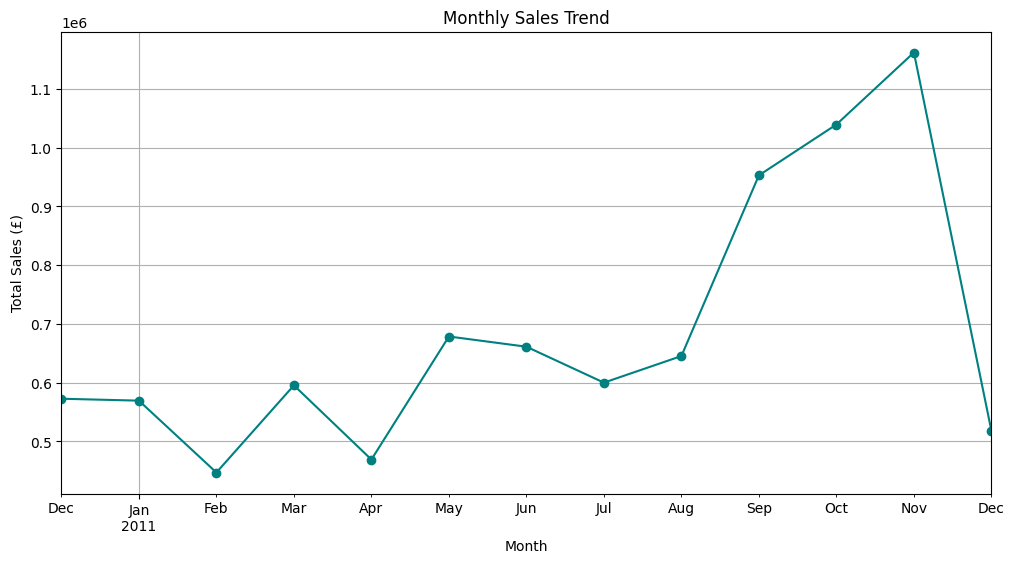

In [73]:
# Monthly Sales Trend
monthly_sales = df.set_index('InvoiceDate').resample('M')['TotalAmount'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o', color='teal')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.grid(True)
plt.show()


## Top 10 Countries by Revenue

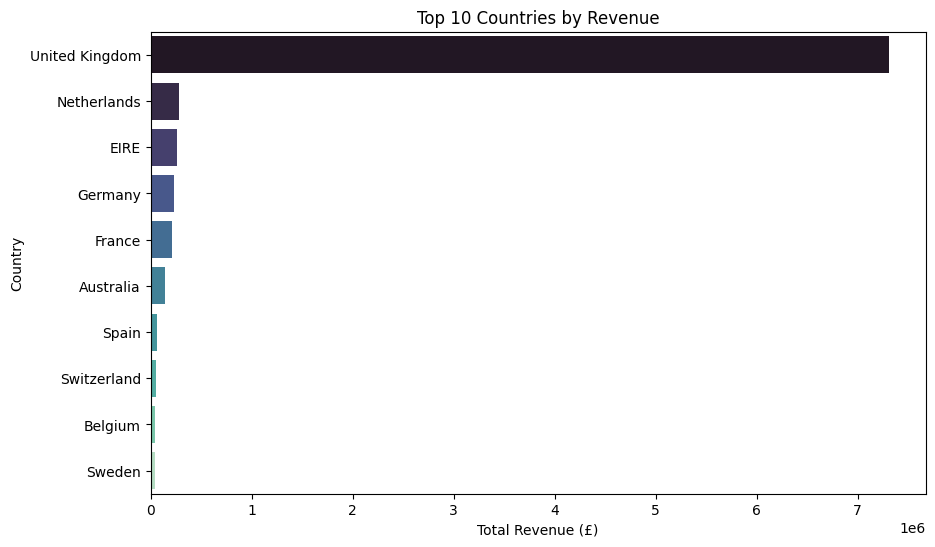

In [74]:
#Top 10 Countries by Revenue
country_sales = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_sales.values, y=country_sales.index, palette='mako')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Country')
plt.show()


## Correlation Heatmap of RFM Features

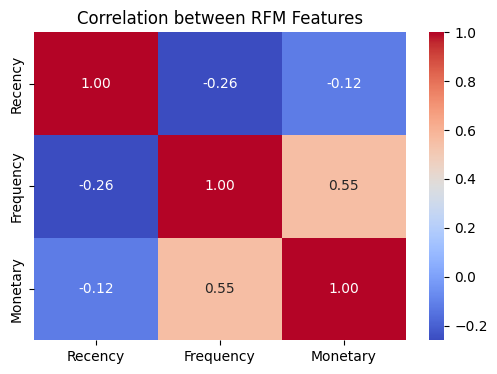

In [75]:
#  Correlation Heatmap of RFM Features

plt.figure(figsize=(6, 4))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between RFM Features')
plt.show()
